## `Laboratorio #5`
### Estudiante: Roy Esteban Padilla Calderón
### Carné: B85854

#### `Paso 1. Carga de los datos:`

In [65]:
# Código preveído por el profesor Pablo Sauma Chacón

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch

# Custom subdirectory to find images
DIRECTORY = "images"

def load_data():
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    names = [n.decode('utf-8') for n in unpickle(DIRECTORY+"/batches.meta")[b'label_names']]
    x_train = None
    y_train = []
    for i in range(1,6):
        data = unpickle(DIRECTORY+"/data_batch_"+str(i))
        if i>1:
            x_train = np.append(x_train, data[b'data'], axis=0)
        else:
            x_train = data[b'data']
        y_train += data[b'labels']
    data = unpickle(DIRECTORY+"/test_batch")
    x_test = data[b'data']
    y_test = data[b'labels']
    return names,x_train,y_train,x_test,y_test

names,x_train,y_train,x_test,y_test = load_data()

def plot_tensor(tensor, perm=None):
    if perm==None: perm = (1,2,0)
    plt.figure()
    plt.imshow(tensor.permute(perm).numpy().astype(np.uint8))
    plt.show()

Comprobación de núcleos CUDA

In [66]:
torch.cuda.is_available() # Checkeo de disponibilidad de CUDA
torch.cuda.empty_cache() # Limpieza de la caché

### `Paso 2. Procesamiento de los datos:`

Note que los datos de las imágenes vienen como un arreglo de datos (tipo uint8) de tamaño 50000x3096, donde cada fila corresponde a una imagen y los 3096 valores corresponden a una imagen de 3x32x32 (los primeros 1024 valores corresponden a la imagen 32x32 del canal rojo, los siguientes 1024 al 32x32 del verde, y por último los 1024 del canal azul). Los labels corresponden a un arreglo de enteros tamaño 50000. En ambos casos deberá convertir los datos a tensores, y en el caso de las imágenes cambiar su forma de 50000x3096 a 50000x3x32x32 (note que el orden de los datos  permanece igual, esto porque las capas convolucionales prefieren que los canales vengan como dimensión superior: CxHxW en lugar del habitual HxWxC; esto por motivos de eficiencia).

In [67]:
COLOR_DIM = 3 # Número de filtros iniciales 3 por ser RGB
IMAGE_DIM = 32 # Dimensiones de la imagen
CLASSIFICATIONS = np.unique(y_train).size # Cantidad de clasificaciones

# Conversión de numpy a tensores
x_train_processed = torch.tensor(np.reshape(x_train, (x_train.shape[0], COLOR_DIM, IMAGE_DIM, IMAGE_DIM)), dtype= torch.float)
x_test_processed = torch.tensor(np.reshape(x_test, (x_test.shape[0], COLOR_DIM, IMAGE_DIM, IMAGE_DIM)), dtype= torch.float)
y_train_processed = torch.tensor(y_train)
y_test_processed = torch.tensor(y_test)

`Valor de y con su correspondiente a la categoría`

| y_value| Name |
|--|--|
| 0| avión|
| 1| automóvil |
| 2| pájaro |
| 3| gato |
| 4| perro |
| 5| venado |
| 6| rana |
| 7| caballo |
| 8| barco |
| 9| camión |

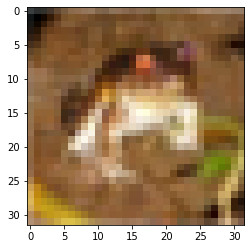

6


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [68]:
DICT_Y = {
    0 : 'avion', 1: 'automovil', 2: 'pajaro', 3: 'gato', 4 : 'perro' , 5 : 'venado' ,
    6: 'rana',  7: 'caballo' , 8: 'barco', 9: 'camion'
}

plot_tensor(x_train_processed[0])
print(y_train[0])
np.unique(y_train)

### `Paso 3. Construcción de la red neuronal:`



In [69]:
from torch import nn
from torch import flatten

class ConvNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Primera convolución
        # Entra una imagen 3x32x32
        self.conv1 =  nn.Conv2d(in_channels = COLOR_DIM, out_channels = 10, kernel_size = (5,5), stride=1, padding= 'same')
        # Sale una imagen de 10x32x32
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        # Imagen de 10x16x16

        # Segunda convolución 
        # Entra una imagen de 10x16x16
        self.conv2 =  nn.Conv2d(in_channels = 10, out_channels = 30, kernel_size = (5,5), stride=1, padding= 'same')
        # Sale una imagen de 30x16x16
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)
        # Sale una imagen de 30x8x8 => vector de 1920

        # Tercera convolución 
        # Entra una imagen de 30x8x8 
        self.conv3 =  nn.Conv2d(in_channels = 30, out_channels = 50, kernel_size = (5,5), stride=1, padding= 'same')
        # Sale una imagen de 50x8x8
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2)
        # Sale una imagen de 50x4x4 => vector de 800

        # Red neuronal
        self.fc1 = nn.Linear(800, 500)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(500, CLASSIFICATIONS)
        self.act2 = nn.Sigmoid() # Se utiliza sigmoide porque CrossEntropy realiza una acción similar a la softmax, además, da mejores resultados
        
    def forward(self, x):
        ''' Sobre escritura del método de forward propagation, aplicando las capas convolucionales
            y luego las capas densas de la red neuronal'''
        # aplicación de la primera convolución
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # aplicación de la segunda convolución
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # salida de 10x5x5
        # aplicación de la tercera convolución
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        # aplanamiento de los datos
        x = flatten(x, 1)

        # Ejecución en la red neuroral
        h = self.act1( self.fc1(x) )
        out = self.act2( self.fc2(h) )
        
        return out

    def get_general_precision(self, y_predict, y_true):
        '''Método de obtención de la exactitud del modelo'''
        corrects = 0
        for index, value in enumerate(y_predict):
            corrects += 1 if torch.argmax(value) == y_true[index] else 0
        return (corrects/y_true.shape[0])*100
  
    def get_confusion_matrix(self, y_predict, y_true):
        '''Método para calcular la matriz de confusión siendo las filas los valores pedichos y las columnas los reales'''
        confusion_matrix  = np.zeros((y_predict[0].shape[0], y_predict[0].shape[0]))
        for index in range(y_true.shape[0]):
            confusion_matrix[torch.argmax(y_predict[index])][y_true[index]] += 1
        
        return confusion_matrix
    
    def get_specific_precision(self, confusion_matrix):
        '''Método para obtener las precisiones del modelo en cada una de las categorías'''
        precisions = {}
        for key in DICT_Y.keys():
            precisions[DICT_Y[key]] = confusion_matrix[key][key] /(np.sum(confusion_matrix[key]) if np.sum(confusion_matrix[key]) != 0 else 1)*100
        return precisions

    def printTable(self,labels, matrix):
        # Impresión de la matriz de forma bonita
        format_row = "{:>9}" * (len(labels) + 1)
        print(format_row.format("", *labels))
        for _class, row in zip(labels, matrix):
            print(format_row.format(_class, *row))

     

`Entrenamiento de la red neuronal:`

torch.Size([50000, 3, 32, 32]) 50000
True
EPOCH:  0 accuracy :  10.432
EPOCH:  1 accuracy :  10.0
EPOCH:  2 accuracy :  10.0
EPOCH:  3 accuracy :  10.363999999999999
EPOCH:  4 accuracy :  11.28
EPOCH:  5 accuracy :  11.818
EPOCH:  6 accuracy :  11.178
EPOCH:  7 accuracy :  10.058
EPOCH:  8 accuracy :  10.014000000000001
EPOCH:  9 accuracy :  10.004
EPOCH:  10 accuracy :  10.016
EPOCH:  11 accuracy :  10.782
EPOCH:  12 accuracy :  11.953999999999999
EPOCH:  13 accuracy :  11.546
EPOCH:  14 accuracy :  10.892
EPOCH:  15 accuracy :  11.952
EPOCH:  16 accuracy :  13.958
EPOCH:  17 accuracy :  15.112
EPOCH:  18 accuracy :  20.727999999999998
EPOCH:  19 accuracy :  20.8
EPOCH:  20 accuracy :  21.512
EPOCH:  21 accuracy :  23.458000000000002
EPOCH:  22 accuracy :  23.968
EPOCH:  23 accuracy :  25.36
EPOCH:  24 accuracy :  26.704
EPOCH:  25 accuracy :  28.693999999999996
EPOCH:  26 accuracy :  31.036
EPOCH:  27 accuracy :  32.568000000000005
EPOCH:  28 accuracy :  34.166000000000004
EPOCH:  29

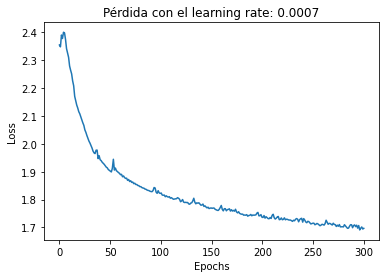

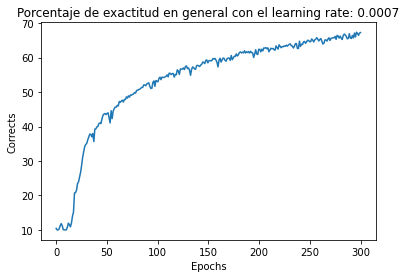

last correct value: 67.258
             avionautomovil   pajaro     gato    perro   venado     rana  caballo    barco   camion
    avion   3446.0     71.0    348.0     83.0    151.0     45.0     35.0    105.0    258.0    113.0
automovil    172.0   4080.0     73.0     60.0     45.0     52.0     69.0     62.0    232.0    835.0
   pajaro    182.0     11.0   2487.0    236.0    303.0    258.0    155.0    112.0     48.0     30.0
     gato    121.0     47.0    418.0   2940.0    324.0   1285.0    370.0    315.0     84.0     67.0
    perro     77.0     20.0    517.0    196.0   3174.0    241.0    245.0    372.0     29.0     25.0
   venado     54.0     20.0    439.0    778.0    231.0   2659.0    117.0    343.0     25.0     41.0
     rana     50.0     41.0    364.0    389.0    294.0    152.0   3832.0     81.0     21.0     49.0
  caballo     41.0     24.0    138.0    111.0    298.0    181.0     39.0   3363.0     13.0     51.0
    barco    618.0    145.0    118.0     98.0    118.0     42.0     59.0 

{'avion': 74.02792696025779,
 'automovil': 71.83098591549296,
 'pajaro': 65.07064364207221,
 'gato': 49.2379835873388,
 'perro': 64.82843137254902,
 'venado': 56.490333545782875,
 'rana': 72.67210316707757,
 'caballo': 78.96219769899038,
 'barco': 74.41272135887243,
 'camion': 69.76744186046511}

In [70]:
device = torch.device("cuda:0")

LEARNING_RATE = 0.0007
model = ConvNN()
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(x_train_processed.shape, len(y_train))
# Carga a la GPU
x_train_processed = x_train_processed.to(device)
y_train_processed = y_train_processed.to(device)
x_test_processed = x_test_processed.to(device)
y_test_processed = y_test_processed.to(device)
model = model.to(device)

torch.cuda.empty_cache()

# Entrenamiento
loss_train = []
corrects = []
EPOCHS = 300

print(x_train_processed.is_cuda)
for i in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train_processed)
    loss = loss_func(y_pred, y_train_processed)
    loss.backward()
    optimizer.step()
    loss_train.append(loss.item())
    corrects.append(model.get_general_precision(y_pred,y_train_processed))
    print('EPOCH: ', i, 'accuracy : ', corrects[-1])
    torch.cuda.empty_cache()

# Impresión de gráficos y resultados del modelo
len_ = len(loss_train)
xpoints = np.linspace(0, len_, num = len_)
plt.plot(xpoints, loss_train)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(("Pérdida con el learning rate: " + str(LEARNING_RATE)))
plt.show()

plt.plot(xpoints, corrects)
plt.xlabel("Epochs")
plt.ylabel("Corrects")
plt.title(("Porcentaje de exactitud en general con el learning rate: " + str(LEARNING_RATE)))
plt.show()
print("last correct value:", corrects[-1])

confusion_matrix = model.get_confusion_matrix(model(x_train_processed), y_train_processed)
model.printTable(DICT_Y.values(), confusion_matrix)
model.get_specific_precision(confusion_matrix)

`Evaluación del modelo con el dataset de testing:`

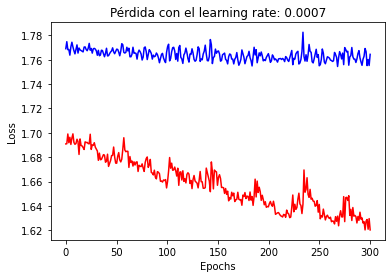

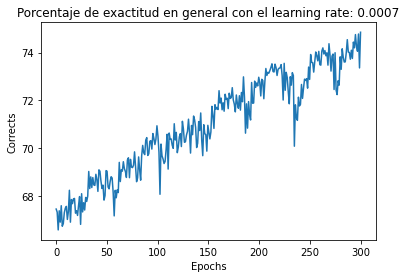

last correct value: 74.85199999999999
             avionautomovil   pajaro     gato    perro   venado     rana  caballo    barco   camion
    avion    619.0     12.0     51.0     10.0     19.0      9.0      7.0     13.0     35.0     22.0
automovil     18.0    660.0      2.0      9.0      5.0      0.0      5.0      1.0     35.0     72.0
   pajaro     66.0     11.0    541.0    100.0    103.0     80.0     72.0     47.0     13.0     20.0
     gato     15.0     23.0     80.0    445.0     56.0    184.0     85.0     40.0     17.0     29.0
    perro     24.0      9.0     98.0     65.0    571.0     48.0     82.0     60.0     13.0      7.0
   venado     21.0     11.0     88.0    211.0     56.0    559.0     50.0     66.0     11.0     10.0
     rana     14.0     15.0     45.0     63.0     46.0     22.0    648.0      9.0      8.0     18.0
  caballo     25.0     18.0     57.0     58.0    110.0     73.0     23.0    740.0      6.0     40.0
    barco    147.0     65.0     29.0     19.0     28.0     14.

{'avion': 77.66624843161857,
 'automovil': 81.78438661710037,
 'pajaro': 51.37701804368471,
 'gato': 45.687885010266946,
 'perro': 58.44421699078812,
 'venado': 51.61588180978762,
 'rana': 72.97297297297297,
 'caballo': 64.34782608695652,
 'barco': 67.42485783915517,
 'camion': 68.26923076923077}

In [71]:
loss_train = []
loss_test = []
corrects = []

for i in range(EPOCHS):
    # Entrenamiento
    model.train()
    optimizer.zero_grad()
    y_pred = model( x_train_processed )
    loss = loss_func(y_pred, y_train_processed)
    loss.backward()
    optimizer.step()
    # Evaluación
    model.eval()
    with torch.no_grad(): # Apaga el cálculo de gradientes
        loss2 = loss_func( model(x_test_processed), y_test_processed)
    loss_train.append(loss.item())
    loss_test.append(loss2.item())
    corrects.append(model.get_general_precision(y_pred, y_train_processed))

# Impresión de gráficos y resultados del modelo
len_ = len(loss_train)
xpoints = np.linspace(0, len_, num = len_)
plt.plot(xpoints, loss_train, color = 'red')
plt.plot(xpoints, loss_test, color = 'blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(("Pérdida con el learning rate: " + str(LEARNING_RATE)))
plt.show()

plt.plot(xpoints, corrects)
plt.xlabel("Epochs")
plt.ylabel("Corrects")
plt.title(("Porcentaje de exactitud en general con el learning rate: " + str(LEARNING_RATE)))
plt.show()
print("last correct value:", corrects[-1])

confusion_matrix = model.get_confusion_matrix(model(x_test_processed), y_test_processed)
model.printTable(DICT_Y.values(), confusion_matrix)
model.get_specific_precision(confusion_matrix)

`Guardado del modelo:`

In [72]:
model_filename = 'modelo-{}-{}'.format(EPOCHS, LEARNING_RATE)

torch.save({
    'model_state': model.state_dict(),
    'opt_state': optimizer.state_dict(),
    'epoch' : EPOCHS
}, model_filename)

### `Paso 8. Respuestas y análisis: `

Si se encuentra satisfecho con su red, entonces grafique la matriz de confusión para las diferentes categorías. 

¿Cuáles categorías confunde su red? ¿Por qué cree que esas categorías le generan confusión/errores de clasificación?

En el laboratorio se notó que al utilizar en la capa de salida la función `Sigmoide` se obtienen mejores resultados y además permite tasas de aprendizaje más elevadas, con lo cual se utilizó esta para la elaboración de la red neural.

Entorno al proceso de testeo y entrenamiento se puede observar que conforme avanzan las épocas el modelo en general mejora bastante su comportamiento. Como se observa en el gráfico de pérdida del testing este valor tiende a disminuir conforme avanzan las épocas en el entrenamiento (línea color rojo) mas no en el testing (línea color azul), lo cual indica que el sistema puede estarse sobreajustando, por otra parte, en el gráfico de accuracy o exactitud de testing se observa que dicho valor aumenta con cada iteración, por lo que con estos gráficos se nota que el modelo realmente mejora y tiende a mejorar conforme avanzan la épocas y se aplican las técnicas de desenso del gradiente y demás para mejorarlo.

Con respecto al comportamiento en las categorías se nota que en general la exactitud del modelo es buena, alcanzando así una de `74.8%` lo cual es bastante aceptable. Ahora, de manera más específica, como se nota en la matriz de confusión y posteriormente en las impresiones de las precisiones, el modelo tiene un mejor comportamiento al clasificar los vehículos mas no es así con los animales, donde se obtienen valores más bajos. De forma más detallada se observa un comportamiento donde entre los mismos vehículos la red se confunde, y hay más errores prediciendo que sea automóvil, avión, barco y camión cuando el valor real pertenece a estas mismas categorías, por lo que se esperaría que si se está prediciendo una imagen que es algún vehículo la red si falla lo más probable es que su respuesta sea otro vehículo. Este comportamiento también se ve dentro de los animales, donde la red se confunde entre ellos teniendo mayor cantidad de errores al predecir otro animal que un vehículo. 

En conclusión la red tiene un mejor comportamiento al clasificar imágenes de vehículos que las de animales, esto puede ser porque los vehículos tienen formas o contornos más generales y sencillos de distinguir, sin embargo, esto no sucede así con los animales donde estos pueden tener características más específicas que los diferencien, por ejemplo la red cuando predijo gato erró al confundirlo en multiples ocasiones con un venado. 

En general, desde mi punto de vista la red tiene un buen comportamiento a pesar de que las imágenes sean de un tamaño muy comedido causando que no se observen en tanto detalle características más específicas, con lo cual, se esperaría que si se utilizaran imágenes de más resolución se tenga un mejor comportamiento aunque el procesamiento sea más lento. Como aspectos a mejorar están realizar más pruebas variando el tamaño del kernel y los filtros que se generan en cada una de las convoluciones, ya que considero que el modelo es bastante pesado y puede mejorarse para ser más eficiente conservando los resultados o bien superándolos.